# Práctica 2 Redes Feedforward

* García Elorza Uriel
* Isra
* Leo

Esta práctica consiste en a construcción e implementación de una **Red Neuronal Feedforward**. Se utiliza la estructura de **gráficas computacionales** para implementar este algoritmo. Adicional a esto, se realiza un entrenamiento utilizando el método de **mini batches** o mini lotes y el optimizador **Adam**.

### Redes Feedforward
El siguiente código sigue una notación matemática en muchas de las secciones, por lo que es conveniente definir las variable involucradas y poder enclarecer el código.

Para ello definamos una Red Feedforward:
Es una función $f:X \rightarrow Y$ donde $X$ es un conjunto de datos y $Y$ es su salida asociada. La forma funcional de la red es:
$$ f(x) = \phi( \bm W^{(k)} \cdot \bm h^{(k)}(x) + \bm b^{(k)} ) $$ 

Donde $\phi: \mathbb{R}^{m_k} \rightarrow \mathbb{R}^{m_k} $ es la función vectorial de **activación** de la capa de salida. $a^{(k)} = \bm W^{(k)} \cdot \bm h^{(k)}(x) + \bm b^{(k)}$ es la **preactivación** de la capa de salida. $ \bm W^{(k)} \in \mathbb(R)^{m_{k-1} \times m_k}$ es una **matriz de pesos** de $m_{k-1} \times m_k$ y $\bm b^{(k)}  \in \mathbb{R}^{m_k}$ un vector llamado **bias** o sesgo; donde $m_{k-1}$ es el número de unidades ocultas de la capa $k-1$ y $m_k$ es la dimensión de la salida de la red.

Así mismo se definan las capas de la Red Feedforward:
$$ h^{(0)}(x) = x $$

$$ h^{(1)}(x) = g_1( \bm W \cdot \bm h^{(0)}(x) + \bm b^{(1)} ) $$
$$ h^{(i)}(x) = g_i( \bm W \cdot \bm h^{(i-1)}(x) + \bm b^{(i)} ) $$ 

Con $i = {1,...,k-1}$ siendo $a^{(i)} = \bm W^{(i)} \cdot \bm h^{(i-1)}(x) + \bm b^{(i)}$ la preactivación de la capa $i$-ésima. $g_i: \mathbb{R}^{m_i} \rightarrow \mathbb{R}^{m_i}$ una función vectorial. Además $\bm W^{(i)} \in \mathbb(R)^{m_{i-1} \times m_i}$ es la matriz de pesos de $m_{i-1} \times m_i$ y $\bm b^{(i)} \in \mathbb{R}^{m_i}$ el sesgo de la capa $i$-ésima

Importamos las bibliotecas que se utilizarán para el código

In [43]:
from abc import ABC, abstractmethod
from typing import Optional, Tuple, List
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


### 1. Construimos la clase abstracta Nodo
Para definir la base de las gráficas computacionales, necesiamtos de estos elementos. Cada nodo va a tener un valor de salida **output** y un valor de su derivada o gradiente **grad**. Además hay nodos que van a tener pesos que eventualmente necesitarán actualizarse, para ello se define el booleano **has_weights**

Además cada nodo va a tener una función para evaluarse **forward** donde va a recibir un valor de entrada x y devolverá su respectiva asignación, dependiendo el tipo de función que sea. 

También tendrá un método **backward** para calcular la derivada de dicho nodo, multiplicándola por la derivada de los nodos anteriores con el fin de seguir la regla de la cadena

In [44]:
class Node(ABC):
    '''Clase base abstracta para nodos en una red neuronal.'''

    def __init__(self, has_weights: bool = False):
        self.output: np.ndarray | float = None # type: ignore
        self.grad: np.ndarray | Tuple[np.ndarray, ...] | None = None
        self.has_weights = has_weights

    def __call__(self, *x) -> np.ndarray:
        return self.forward(*x)

    @abstractmethod
    def forward(self, x) -> np.ndarray:
        '''Ejecuta la operación de propagación hacia adelante para este nodo..'''

    @abstractmethod
    def backward(self, incoming_grad) -> np.ndarray | None:
        '''Calcula el gradiente durante la retropropagación para este nodo.'''

### Funcione de Activación
#### 2.1 Función de Preactivación
El nodo *Linear* define la función de preactivación $$a^{(k)} = \bm W^{(k)} \cdot \bm h^{(k-1)}(x) + \bm b^{(k)}$$ Donde los valores iniciales son aleatorios.

La derivadas parciales para esta función, dependen si es con respecto a los pesos o al sesgo.
$$ \frac{\partial a^{(k)}}{\partial W^{(k)}_{i,j}} = h^{k-1}_{j} \quad \frac{\partial a^{(k)}}{\partial b^{(k)}_{i,j}} = 1 $$

Notemos que si tenemos un gradiente en la capa anterior con quien es necesario utilizar la regla de la cadena, multiplicamos la derivada de esta capa, con la anterior en un producto exterior.

In [45]:
class Linear(Node):

    def __init__(self, input_size: int, output_size: int):
        super().__init__(has_weights = True)
        # Generamos la matriz de pesos W y el sesgo b con los tamaños de entrada y salida
        self.w = np.random.rand(output_size, input_size) # filas neuronas, columnas pesos
        self.b = np.random.rand(output_size)[:, np.newaxis] # [:, np.newaxis] tranforma en un vector columna
        self.h: Optional[np.ndarray] = None # salida de la capa anterior
    
    def forward(self, x) -> np.ndarray:
        self.h = x
        self.output = np.dot(self.w, self.h) + self.b
        return self.output
    
    def backward(self, incoming_grad) -> None:
        grad_w = np.zeros_like(self.w)
        grad_b = np.zeros_like(self.b)
        for i in range(incoming_grad.shape[-1]):
            # Aplicamos producto exterior del gradiente de Linear con el d_k anterior
            grad_w += np.outer(incoming_grad[:,i], self.h[:, i])
            grad_b += incoming_grad[:,i][:, np.newaxis]

        self.grad = grad_w, grad_b

#### 2.2 Función ReLU (Rectified Linea Unit)
El nodo *ReLU* define la función vectorial de activación $ ReLU(\bar{x}) = (ReLU(x_0), ReLU(x_1), ... , ReLU(x_{m_k}))$ donde
$$ ReLU(x_i) = \begin{cases} 
    x_i \quad \textnormal{si } x_i > 0 \\
    0 \quad \textnormal{si }  x_i \leq 0
 \end{cases} $$

La derivada parcial (abusando de notación) para esta función es:
$$
 \quad \frac{\partial}{\partial \bar{x}} ReLU(\bar{x}) = \left( \frac{\partial}{\partial x_0} ReLU(x_0), ... ,\frac{\partial}{\partial x_{m_k}} ReLU(x_{m_k}) \right)
 $$
Donde 
$$ \frac{\partial}{\partial x_i} ReLU(x_i) = \begin{cases} 
    x_i \quad \textnormal{si } x_i > 0 \\
    0 \quad \textnormal{si }  x_i \leq 0
 \end{cases} $$

Notemos que esto ocurre porque estamos tomando en cuenta todo, entrada por entrada.

Además, multiplicamos uno a uno por la derivada anterior, para calcular regla de la cadena de alguna función mayor (como la de costo).

In [46]:
class ReLU(Node):
    
    def __init__(self):
        super().__init__()
        self.a: Optional[np.ndarray] = None # preactivacion

    def forward(self, x):
        self.a = x
        self.output = np.maximum(0, self.a) # funcion de maximo aplicado a cada entrada
        return self.output
    
    def backward(self, incoming_grad):
        self.grad = incoming_grad * (self.a > 0) # (self.a > 0) es matriz de booleanos (una mascara)
        return self.grad

#### 2.3 Función Tanh
El nodo *Tanh* (tangente hiperbólica) define la función vectorial de activación $ tanh(\bar{x}) = (tanh(x_0), tanh(x_1), ... , tanh(x_{m_k}))$ donde


La derivada parcial (abusando de notación) para esta función es:
$$
 \quad \frac{\partial}{\partial \bar{x}} tanh(\bar{x}) = \left( \frac{\partial}{\partial x_0} tanh(x_0), ... ,\frac{\partial}{\partial x_{m_k}} tanh(x_{m_k}) \right)
 $$
Donde 
$$ \frac{\partial}{\partial x_i} tanh(x_i) = 1 - tanh(x_i)^2 $$

Notemos que esto ocurre porque estamos tomando en cuenta todo, entrada por entrada.

Además, multiplicamos uno a uno por la derivada anterior, para calcular regla de la cadena de alguna función mayor (como la de costo).

In [47]:
class Tanh(Node):

    def __init__(self):
        super().__init__()
        self.a: Optional[np.ndarray] = None

    def forward(self, x):
        self.a = np.clip(x, -18.5, 18.5) # evitando errores numericos pues np.tanh(19) = 1 !
        self.output = np.tanh(self.a)
        return self.output 

    def backward(self, incoming_grad):
        self.grad = incoming_grad * (1 - self.output ** 2)
        return self.grad

#### 2.4 Función Softmax
El nodo *Softmax*  define la función vectorial de activación 
$ Softmax(\bar{x}) = (S_0(\bar{x}), S_1(\bar{x}), ... , S_{m_k}(\bar{x})) $ tal que
$$ S_i(\bar{x}) \frac{e^{x_i}}{\sum_{j=i}^{m_k} e^{x_j} }$$


Para el caso de la softmax, al ser una función vectorial que no está definida a partir de funciones escalare como las demás, es necesario calcular la matriz derivada $D(Softmax)(\bar{x})$, es decir su jacobiano. El cual está con las siguientes entradas
$$
   [ D(Softmax)(\bar{x}) ]_{i,j} = S_i(\bar{x}) ( \delta_{ij} - S_j(\bar{x}))
$$
Donde 
$ \delta_{ij} $ es la Delta de Kronecker

En este caso, para aplicar al vector del nodo superior, es necesario realizar un multiplicación de matriz-vector y no un producto uno a uno como en los otros casos

In [48]:
def kronecker_delta(x,y):
    if x == y:
        return 1
    else:
        return 0

class Softmax(Node):

    def __init__(self):
        super().__init__()
        self.a: Optional[np.ndarray] = None   

    def forward(self, x) -> np.ndarray:
        # evitando errores numericos pues np.exp(-746) = 0.0 y np.exp(710) = inf
        self.a = np.clip(x, -709, 709) 
        exp_a = np.exp(self.a)
        sum_column = np.sum(exp_a, axis=0) # vector con las sumas aculadas de cada columna
        self.output = exp_a / sum_column # division de cada elemento por su suma de columna correspondiente
        return self.output
    
    def backward(self, incoming_grad) -> np.ndarray:
        # Calculamos el Jacobiano de la Softmax y se lo aplicamos al gradiente del padre

        self.grad = np.zeros_like(self.output.T) # Gradiente con dimensiones del output

        # Iteramos sobre columnas, es decir por cada dato (no por cada variable)
        for column_index in range(self.output.shape[1]):

            column = self.output.T[column_index] # Un sólo dato con la softmax
            x_size = len(column)

            # Construimos el jacobiano
            J =  np.zeros((x_size, x_size))
            for i in range(x_size):
                for j in range(x_size):
                    J[i][j] = column[i] * ( kronecker_delta(i,j) - column[j])

            # Aplicamos el producto a la columna correspondiente, por eso transponemos
            self.grad[column_index] = np.dot(J, incoming_grad.T[column_index])
        
        self.grad = self.grad.T # Se usa la transpuesta para mantener las dimensiones correctas

        return self.grad


### 3. Función de Error
#### 3.1 Entropía Cruzada

La entropia cruzada es una función que se utiliza comunmente para diferenciar entre dos o más distribuciones de variables aleatorias. En este caso se utilizará como función de pérdida para el problema de clasificación. Con el objetivo de entrenar a la red para que obtenga las probabilidades de que un valor de entrada $\bar{x}$ esté en una cierta clasificación $y$.

La definición utilizada es: 
$$ E(X,Y) = - \sum_{\bar{x} \in X} y_{\bar{x}} ln(\hat{y}_{\bar{x}}) $$

Donde $\hat{y} = f(\bar{x})$ la predicción hecha por la red y $y_x \in Y$ es la etiqueta real del valor $\bar{x}$.

También tenemos que la derivada de la entropía cruzada es
$$ \frac{\partial E(X,Y)}{\partial X} = \left( \frac{\partial E(X,Y)}{\partial \bar{x}_0}, ... , \frac{\partial E(X,Y)}{\partial \bar{x}_{\textnormal{last datum}}} \right) $$

Donde 
$$ \frac{\partial E(X,Y)}{\partial \bar{x}_i} = - \frac{y_{\bar{x}_i}}{\hat{y}_{\bar{x}}} $$

In [49]:
class CrossEntropy(Node):
    
    def __init__(self,):
        super().__init__()
        self.epsilon = 1e-9
    
    def forward(self, y_pred, y_real) -> np.ndarray:
        entry_contribution = y_real * np.log(y_pred + self.epsilon)
        self.output = - np.sum(entry_contribution, axis=0)
        return self.output 

    def backward(self, y_pred, y_real) -> np.ndarray:
        return - (y_real / (y_pred + self.epsilon))

### 4. Forward Propagation (Propagación)
Para definir una Red Feedforward, es necesario definir la **arquitectura** de la red. Es decir, definir la funciones que se van a utilizar en las capas oculatas, la función de la capa de salida, la función de error, así como la cantidad de nodos o unidades ocultas que va a tener cada capa.

Esto se define en los atributos **layers** donde están todos los nodos, es decir los de preactivación y los de activación (mismos que ya están instanciados con sus parámetros adecuados). También guarda el nodo de la función de error en **error_node**. Y por último, para el entrenamiento, nos interesa sólo las capas con pesos, es decir las de preactivación, por ello las guardamos en otra variable como **weighted_layers**

Definimos una método **evaluate** que recibe los datos que se van a pasar por la red. Esto es útil no solo para entrenarla, sino para poder utilizar la red con facilidad cambiando solamente los datos. Esta función lo que hace es recorrer cada una de las capas, es decir, de los nodos de la gráfica computacional y mandar las salidas de la capa anterior a la siguiente. Es aquí donde se crea el encadenamiento de la Red Neuronal. Finalmente se guarda el valor en **output**

##### Nota
Para la comprensión del código, cabe mencionar que se ejecuta en mini lotes, es decir la entrada es una matriz donde cada columna es un dato diferente y cada renglón son las diferentes variables que tiene. Es decir:
$$ f(X) = f( [\bar{x}_1 \; \bar{x}_2 \; ... \; \bar{x}_{\textnormal{last}}] ) \quad \bar{x}_i =  \begin{bmatrix}
           x_{i, 0} \\
           x_{i, 1} \\
           \vdots \\
           x_{i, m_k}
         \end{bmatrix}$$

Así, la salida de la red también es una matriz donde la $i$-ésima columna es la salida del $i$-ésimo dato $\bar{x}_i$.
$$ f(X) = [ f(\bar{x}_1) \; f(\bar{x}_2) \; ... \; f(\bar{x}_{\textnormal{last}})] $$

### 5. Backpropagation (Retropropagación)

Para poder entrenar la red, es necesario calcular la de la función de error con respecto a los pesos de entrenamento y al sesgo, de cada una de las capas. De forma general esta está definida como:
$$ R(\theta) = \sum_{(\bar{x},y_{\bar{x}})} L(y_{\bar{x}}, f_y(\bar{x};\theta)) $$

Con $L4 una función de pérdida. En este caso $R(\theta)$ es la entropía cruzada.

Así, el algoritmo de retropropagación nos dice que se haga lo siguiente:

Inicializamos el vector $d^{(k+1)} \in \mathbb{R}^{m_k}$ un vector del tamaño de la salidas de la red.
$$ d^{(k+1)}_i = \frac{\partial L(y, f_y(\bar{x}))}{\partial f_y(\bar{x})}  \frac{\partial f_y(\bar{x})}{\partial a_i^{(k+1)}} $$

Luego sobre todas las capas $l = k, k-1, ... , 1$ generamos los vectores $d^{(l)} \in \mathbb{R}^{m_{l-1}}$ como:
$$ d^{(l)}_i = \frac{\partial h_i^{(l)}}{\partial a_i^{l}} \sum_{q=0}^{m_l} d_q^{l+1} W^{l+1}_{q,i}$$

Finalmente las derivadas de la función de error respecto a los pesos se obtienen como:
$$
\frac{\partial R(\theta)}{\partial W_{i,j}^{l}} = d_i^{(l)}h_j^{(l-1)} \quad \frac{\partial R(\theta)}{\partial b_{i}^{l}} = d_i^{(l)}
$$

Recordemos que todo esto se escribió para que fuese más claro de entender qué es cada variable del código, en especial los vectores particulares d_k y las d_kp1 $ = d^{k+1}$

Finalmente, el método **backpropagate** realiza el algoritmo de retropropagación sobre todas las capas, debido a que éste es algo complicado de ejecutar si no se tiene un control dentro de los nodos, por eso se ejecuta iterando sobre todas las derivadas que se calculan con los métodos backward de las capas.

Después de ejecutar esto, cada nodo tiene su derivada correspondiente con respecto a la función de error, y ya se pueden usar los gradientes dentro de los nodos para poder optimizar los pesos y los sesgos

#### Entrenamiento
El método **train** recibe un objeto optimizador y lo ejecuta para entrenar la red

In [50]:
class Neural_Network():
    
    def __init__(self, *layers: Tuple[Node, ...], error_node=None):
        super().__init__()
        self.layers: Tuple[Node, ...] = layers
        self.error_node: Node = error_node
        self.weighted_layers: List[Node] = [] # Nodos/capas con pesos

        for layer in layers:
            if layer.has_weights:
                self.weighted_layers.append(layer)
        
    def evaluate(self, x: np.ndarray) -> np.ndarray:
        x = x.T
        if x.ndim == 1: # si solo es un dato se transforma a vector columna
            x = x[:, np.newaxis]
        actual_val = x
        
        for layer in self.layers:
            actual_val = layer(actual_val)
        self.output = actual_val.T # Se quiere que las salidas sean consistentes.

        return self.output
    
    def backpropagate(self, labeles_of_data) -> None:
        # Primer paso del algoritmo
        dL_df = self.error_node.backward(self.output.T, labeles_of_data.T)

        i = len(self.layers) - 1
        d_kp1 = self.layers[i].backward(dL_df)
        self.layers[i - 1].backward(d_kp1)
        w_kp1 = self.layers[i - 1].w
        i -= 2
        
        # Segundo paso
        for weighted_layer in reversed(self.weighted_layers[:-1]):
            d_k = self.layers[i].backward(np.dot(w_kp1.T, d_kp1))
            weighted_layer.backward(d_k)
            d_kp1 = d_k
            w_kp1 = self.layers[i - 1].w
            i -= 2

    def train(self, optimizer):
        optimizer.network = self
        optimizer.optimize()
        
        return


### 6. Mini Batches (Mini Lotes)

El los algoritmos de optimización, suelen calcular la derivada de los datos con respecto a los pesos, pero usando todos los datos. Calcular dicha derivada, es muy pesado computacionlamente, por ello, es convenientes usar sólo una parte de los datos calcular la derivada sólo de esos datos y ejecutar un paso en el algoritmo de optimización.

Para ello se definen los mini batches o mini lotes que no son más que una **partición de los datos** de entrenamiento, partición en el sentido matemático. (La unión es el total y las intersecciones son vacías).

Generamos los mini lotes, dividiendo los datos en conjuntos de tamaños **batch_size** con sus respectivas etiquetas. Además los mini lotes deben contener los datos de forma aleatoria.

In [51]:
def create_mini_batches(X, Y, batch_size):
    mini_batches = []
    # arreglo con los indices de cada dato 
    indices = np.arange(X.shape[0]) 
    # los mezclamos para tomar al azar
    np.random.shuffle(indices) 

    # Dividimos en mini-batches
    for i in range(0, X.shape[0], batch_size):
        batch_indices = indices[i:i + batch_size]
        X_batch = X[batch_indices]
        Y_batch = Y[batch_indices]
        mini_batches.append((X_batch, Y_batch))

    return mini_batches

### 7. Algoritmos de optimización
Son métodos para encontrar el mínimo de la función de costo (error) y son los que entrenan la red neuronal. Existen varios, y por lo mismo, este código está hecho para poder utilizar diferentes algoritmos de optimizción.

En el código, cada algoritmo es un objeto que recibe los datos de entrenamiento con sus etiquetas **X_train** y **Y_train**, guardándolos como **x** y **y**. También recibe la cantidad de veces que se ejecuta el algoritmo **epochs** y el tamaño de los mini lotes en los que va a particionar los datos **mini_batches_size**. Adicionalmente, recibe los diferentes hiperparámetros para el entrenamiento.



#### 7.1 Descenso por Gradiente

El algoritmo de optimización es el más básico para el entrenamiento de las redes neuronales, muy usado por su simplicidad. Consiste en optimizar los pesos utilizando el gradiente de la función de error.

Este algritmo tiene un parámetros $\eta$ el cual es latasa de aprendizaje

Una vez calculado el gradinte (derivada) actualizamos los pesos $\theta$ con la siguiente expresión:
$$ \theta_{t+1} \leftarrow \theta_t - \eta \nabla_\theta R(\theta) $$

#### Observaciones
También es importante mencionar que como los datos están en mini lotes, las derivadas son matrices, donde cada columna es la derivada de la función de error con respecto a uno de los datos.

También como las derivadas con respecto a los pesos y los sesgos son diferentes, entonces se manejan de forma independiente al actualizarse

In [52]:
class Gradient_Descent():
    def __init__(self, X_train, Y_train, learning_rate, epochs, mini_batches_size = 1):
        self.x = X_train
        self.y = Y_train
        self.lr = learning_rate
        self.epochs = epochs

        y_one_hot = np.eye(2)[Y_train.astype(int)]

        self.mini_batches = create_mini_batches(X_train, y_one_hot, mini_batches_size)
        self.network = None
        

    def optimize(self):
        print("Optimizing ... ")

        for _ in tqdm(range(self.epochs)):
            for x_batch, y_batch in self.mini_batches:
                self.network.evaluate(x_batch) # forward
                self.network.backpropagate(y_batch)

                for layer_with_weights in self.network.weighted_layers: # iteramos los nodos/capas con pesos y los actualizamos
                    layer_with_weights.w -= self.lr * layer_with_weights.grad[0]
                    layer_with_weights.b -= self.lr * layer_with_weights.grad[1]

        print("Done")
        

#### 7.1 AdaGrad

El algoritmo de optimización AdaGrad (Adaptative Gradient) es una mejora del Descenso del gradiente. Consiste en optimizar los pesos pero de forma adaptativa utilizando un vector de momento que determine qué tanto afectan las derivdas de la época actual, con el fin de alcanzar el óptimo en una cantida de pasos menor y al mismo tiempo evitar el sub ajuste.

Este algritmo tiene igualmente el parámetro $\eta$, la tasa de aprendizaje.

Además el algoritmo consta de un vector adicional, el de momento $\mu$, el cual para un tiempo $t$ de ejecución, es decir el $t$-ésimo paso, se actualiza como:
$$ \mu_t \leftarrow \mu_{t-1} + (\nabla_\theta R(\theta_t))^2 $$

Finalmente actualizamos los pesos $\theta$ con la siguiente expresión:
$$ \theta_{t+1} \leftarrow \theta_t - \frac{\eta}{\sqrt{\mu_t} + \varepsilon} \nabla_\theta R(\theta_t) $$

Usalmente se tomar $\varepsilon = 10^{-8}$

In [53]:
class Adagrad():
    def __init__(self, X_train, Y_train, learning_rate, epochs, mini_batches_size = 1):
        self.x = X_train
        self.y = Y_train
        self.lr = learning_rate
        self.epochs = epochs

        y_one_hot = np.eye(2)[Y_train.astype(int)]

        self.mini_batches = create_mini_batches(X_train, y_one_hot, mini_batches_size)
        self.network = None

    def optimize(self):

        print("Optimizing ... ")

        # Ejecutamos la red para obtener los tamaños de los gradientes
        x_batch, y_batch = self.mini_batches[0]
        self.network.evaluate(x_batch)
        self.network.backpropagate(y_batch)

        # Momentos para los pesos
        # Son objetos porque los tamaños dependen de la arquitectura de la red
        mu_w = {}
        mu_b = {}

        for i, weighted_layer in enumerate(self.network.weighted_layers):
            mu_w[i] = np.zeros_like(weighted_layer.grad[0])
            mu_b[i] = np.zeros_like(weighted_layer.grad[1])

        
        epsilon = 1e-8

        for epoch in tqdm(range(self.epochs)):
            for x_batch, y_batch in self.mini_batches:
                self.network.evaluate(x_batch) # forward
                self.network.backpropagate(y_batch)

                # iteramos los nodos/capas con pesos y los actualizamos
                for i, layer_with_weights in enumerate(self.network.weighted_layers): 
                    # Actualizamos los momentos
                    mu_w[i] = mu_w[i] + layer_with_weights.grad[0]**2
                    mu_b[i] = mu_b[i] + layer_with_weights.grad[1]**2
                    
                    # Actualizamos los pesos
                    layer_with_weights.w -= self.lr/(np.sqrt(mu_w[i]) + epsilon) * layer_with_weights.grad[0]
                    layer_with_weights.b -= self.lr/(np.sqrt(mu_b[i]) + epsilon) * layer_with_weights.grad[1]

        return

#### 7.3 Adam

El algoritmo de optimización Adam (Adaptative Momentum) es un estándar para el entrenamiento de las redes neuronales por su efectividad. Consiste en optimizar los usando el gradiente de la función de error pero de forma adaptativa al igual que Adagrad, sin embargo, ahora el momento con el cual se adapta el gradiente, es el adaptativo y no el gradinte en sí , con el fin de alcanzar el óptimo en una cantida de pasos menor y al mismo tiempo evitar el sub ajuste.

Este algritmo tiene tres parámetros $\eta \; ,\beta_1 \; , \beta_2$ los cuales definen el comportamiento del algoritmo. La primera es la tasa de aprendizaje y los segundos son tasas de adaptación.

Además el algoritmo consta de dos vectores adicionales, el de momento $\mu$ y el de adaptación del momento $\nu$ los cuales para un tiempo $t$ de ejecución, es decir el $t$-ésimo paso, se actualizan como:
$$ \mu_t \leftarrow \beta_1 \mu_{t-1} + (1-\beta_1) \nabla_\theta R(\theta_t) $$
$$ \nu_t \leftarrow \beta_2 \nu_{t-1} + (1-\beta_2) (\nabla_\theta R(\theta_t))^2 $$

Donde elevar al cuadrado es un abuso de notación a elevar el cuadrado cada entrada del vector gradiente.

Luego, normalizamos los vectores de la siguiente forma:
$$ \hat{\mu}_t = \frac{\mu_t}{1-\beta_1} \quad \hat{\nu}_t = \frac{\nu_t}{1-\beta_2} $$

Finalmente actualizamos los pesos $\theta$ con la siguiente expresión:
$$ \theta_{t+1} \leftarrow \theta_t - \frac{\eta}{\sqrt{\hat{\nu_t}} + \varepsilon} \hat{\mu_t} $$

Usalmente se tomar $\varepsilon = 10^{-8}$

##### Observaciones
Numpy no permite tener arreglos en los que cada entrada sea un arreglo con dimensiones diferentes. Es decir, numpy.array deben ser tensores, por fuerza. Sin embargo, los vectores $\mu$ y $\nu$ dependen de la cantidad de pesos (o de unidades ocultas) que tenga cada capa. Entonces para poder tener una sola variable que almacene todos los valores de momento y adpatación, para cada una de las capas, se usaron diccionarios como si fueran arreglos y en cada entrada, hay un vector de tipo np.array

También es importante mencionar que como los datos están en mini lotes, las derivadas son matrices, donde cada columna es la derivada de la función de error con respecto a uno de los datos.

También como las derivadas con respecto a los pesos y los sesgos son diferentes, entonces se manejan los vectores de momento y de adaptación de forma independiente.

In [54]:
class Adam():
    def __init__(self, X_train, Y_train, learning_rate, beta_params, epochs, mini_batches_size = 1):
        self.x = X_train
        self.y = Y_train
        self.lr = learning_rate
        self.rates = beta_params
        self.epochs = epochs

        y_one_hot = np.eye(2)[Y_train.astype(int)]

        self.mini_batches = create_mini_batches(X_train, y_one_hot, mini_batches_size)
        self.network = None

    def optimize(self):

        print("Optimizing ... ")

        # Ejecutamos la red para obtener los tamaños de los gradientes
        x_batch, y_batch = self.mini_batches[0]
        self.network.evaluate(x_batch)
        self.network.backpropagate(y_batch)

        # Momentos y Adaptaciones para los pesos
        # Son objetos porque los tamaños dependen de la arquitectura de la red
        mu_w = {}
        mu_b = {}
        nu_w = {}
        nu_b = {}

        for i, weighted_layer in enumerate(self.network.weighted_layers):
            mu_w[i] = np.zeros_like(weighted_layer.grad[0])
            mu_b[i] = np.zeros_like(weighted_layer.grad[1])

            nu_w[i] = np.zeros_like(weighted_layer.grad[0])
            nu_b[i] = np.zeros_like(weighted_layer.grad[1])

        
        epsilon = 1e-8

        for epoch in tqdm(range(self.epochs)):
            for x_batch, y_batch in self.mini_batches:
                self.network.evaluate(x_batch) # forward
                self.network.backpropagate(y_batch)

                # iteramos los nodos/capas con pesos y los actualizamos
                for i, layer_with_weights in enumerate(self.network.weighted_layers): 
                    # Actualizamos los momentos
                    mu_w[i] = self.rates[0] * mu_w[i] + (1-self.rates[0]) * layer_with_weights.grad[0]
                    mu_b[i] = self.rates[0] * mu_b[i] + (1-self.rates[0]) * layer_with_weights.grad[1]

                    # Actualizamos las adaptaciones
                    
                    nu_w[i] = self.rates[1] * nu_w[i] + (1-self.rates[1]) * layer_with_weights.grad[0]**2
                    nu_b[i] = self.rates[1] * nu_b[i] + (1-self.rates[1]) * layer_with_weights.grad[1]**2

                    normalized_mu_w = mu_w[i]/(1-self.rates[0])
                    normalized_mu_b = mu_b[i]/(1-self.rates[0])

                    normalized_nu_w = nu_w[i]/(1-self.rates[1])
                    normalized_nu_b = nu_b[i]/(1-self.rates[1])


                    # Actualizamos los pesos
                    layer_with_weights.w -= self.lr/(np.sqrt(normalized_nu_w) + epsilon) * normalized_mu_w
                    layer_with_weights.b -= self.lr/(np.sqrt(normalized_nu_b) + epsilon) * normalized_mu_b

        return

### 8. Funciones Auxiliares
#### 8.1 Generador de clasificaciones circulares
Esta función genera datos aleatorios alredor del punto (0,0), lo hace con diferentes radios, r0 para la clasificación 0 y r1 para la clasificación 1, es decir la idea es generar dos secciones circulares que de clasificaciones distintas. Justo para obtner datos No linealmente separables.

In [55]:
def make_classification(r0=1,r1=3,k=1000):
    """
    Creacion de los datos
    """
    X1 = [np.array([r0*np.cos(t),r0*np.sin(t)]) for t in range(0,k)]
    X2 = [np.array([r1*np.cos(t),r1*np.sin(t)]) for t in range(0,k)]
    X = np.concatenate((X1,X2))
    n,d = X.shape
    Y = np.zeros(2*k)
    Y[k:] += 1
    noise = np.array([np.random.normal(0,1,2) for i in range(n)])
    X += 0.5*noise
    return X,Y

#### 8.2 Generador de gráficas de la red
Esta función grafica los puntos de salida de la red, para comparar con las clasificaciones originales.

In [56]:
def create_plot_of_points(x: np.ndarray, y: np.ndarray, title: str) -> None:

    plt.scatter(x[:,0], x[:,1], s=5, c=np.where(y == 0, 'blue', 'red'))

    blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='Class 0')
    red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='Class 1')

    plt.legend(handles=[blue_patch, red_patch], title='Classes', fontsize='small')
    plt.title(title)

### 9. Prueba de la Red
#### 9.1 Generaración de datos

Generamos 1000 datos de prueba y los separamos en esquema de entrenamiento-validación 70-30

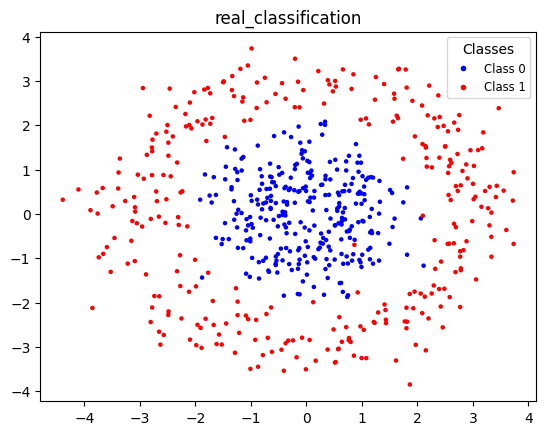

In [57]:
x, y = make_classification(k=1000)
x_train, x_eval, y_train, y_eval = train_test_split(x, y,
test_size=0.3)

create_plot_of_points(x_eval, y_eval, 'real_classification')

#### 9.2 Construcción de la Red Feedforward
Definimos la arquitectura de la red de la siguiente forma:
* Capa de entrada Tanh $2 \rightarrow 10$
* Capa oculta ReLU $10 \rightarrow 5$
* Capa de salida Softmax $5 \rightarrow 2$

Teniendo datos de entrada $\bar{x}$ de tamaño 2. Datos de salida $\hat{y}_{\bar{x}}$ también de tamaño 2 donde la primera entrada es la propabilidad de que el vector de entrada esté en la clasificación 0 $P(\bar{x} = 0) = \hat{y}_{\bar{x},0}$ y la segunda es la probabilidad de que el vector de entrada esté en la clasificación 1 $P(\bar{x} = 1) = \hat{y}_{\bar{x},1}$.

Generamos la red con pesos iniciales aleatorios y observamos que predicen los resultados de forma incorrecta.

pre-training results:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       293
     Class 1       0.51      1.00      0.68       307

    accuracy                           0.51       600
   macro avg       0.26      0.50      0.34       600
weighted avg       0.26      0.51      0.35       600



/home/Uriel/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Uriel/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Uriel/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


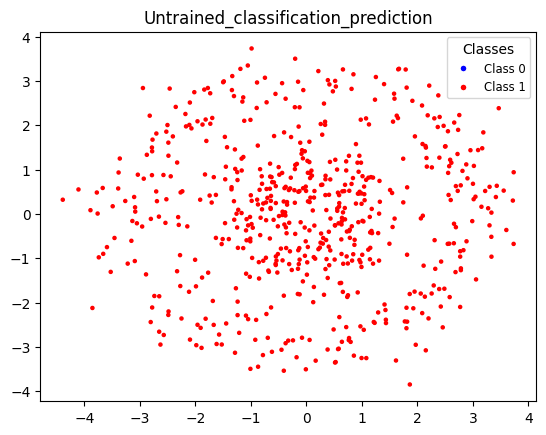

In [58]:
architecture = ( Linear(2, 10), Tanh(), Linear(10, 5), ReLU(), Linear(5, 2), Softmax() )
network = Neural_Network(*architecture, error_node=CrossEntropy())


predictions = network.evaluate(x_eval)
predicted_classes = np.argmax(predictions, axis=1)
report = classification_report(y_eval, predicted_classes, target_names=['Class 0', 'Class 1'])
print('pre-training results:')

print(report)
create_plot_of_points(x_eval, predicted_classes, 'Untrained_classification_prediction')


#### 9.3 Entrenamiento

#### 9.4 Resultados

Utilizando el algoritmo Adam con $\eta = 0.1 \quad \beta_1 = \beta_2 = 0.5$ y ejecutando el algoritmo 100 veces con mini lotes de tamaño 5

Observamos como la clasificación de los datos es mucho mejor. Las métricas están en general por encima de 0.9 y la gráfica saliente tiene un parecido muy grande a la gráfica de las etiquetas reales. Incluso se pueden apreciar las cricunferencias.

In [59]:
optimizer = Adam(x_train, y_train, learning_rate=0.1, beta_params=(0.5,0.5) ,epochs=100, mini_batches_size=5)
network.train(optimizer)

Optimizing ... 


100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


              precision    recall  f1-score   support

     Class 0       0.95      0.91      0.93       293
     Class 1       0.92      0.96      0.94       307

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



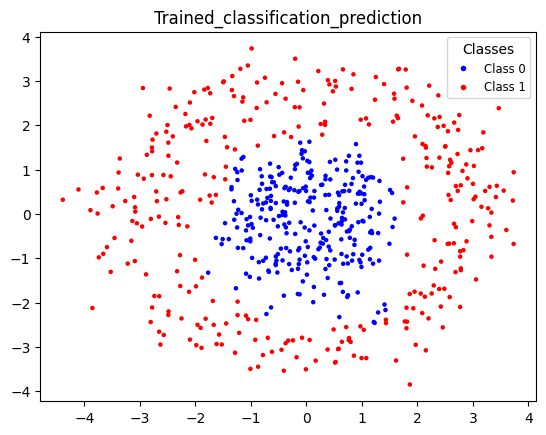

In [60]:
predictions = network.evaluate(x_eval)        
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(y_eval, predicted_classes, target_names=['Class 0', 'Class 1'], zero_division=0)
print(report)

create_plot_of_points(x_eval, predicted_classes, 'Trained_classification_prediction')